In [1]:
import numpy as np
import pandas as pd
import os
import yaml
import cv2
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.transforms import Resize
import time
import os.path as osp
from tqdm import tqdm
from utilities.mask import Create_mask
import pickle

# Load config

In [3]:
def save_pkl(file_path, data):
    with open(file_path, 'wb') as file:
        pickle.dump(data, file)

In [4]:
def get_pkl(file_path):
    with open(file_path, 'rb') as file:
        loaded_list = pickle.load(file)
    return loaded_list

In [5]:
CONFIG_PATH = "configs/"
def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config = yaml.safe_load(file)
    return config

config = load_config("config.yaml")

In [6]:
listl = get_pkl(config['dataset']['index_path'])

In [7]:
mask_ids = [name + ".npy" for name in listl]

# Data read

In [7]:
train_ship_data = pd.read_csv("dataset/train_ship_segmentations_v2.csv")

In [8]:
labels = list(pd.read_csv(osp.join(config['dataset']['dir_path'], 
                                                'train_ship_segmentations_v2.csv'))["EncodedPixels"].fillna('').str.split())
img_ids = list(pd.read_csv(osp.join(config['dataset']['dir_path'], 
                                                'train_ship_segmentations_v2.csv'))["ImageId"])

# Tests

In [25]:
resizer = Resize([config['new_img_size'], config['new_img_size']])

In [18]:
list(train_ship_data[train_ship_data['ImageId']=='000194a2d.jpg']['EncodedPixels'].fillna('').str.split())

[['360486',
  '1',
  '361252',
  '4',
  '362019',
  '5',
  '362785',
  '8',
  '363552',
  '10',
  '364321',
  '10',
  '365090',
  '9',
  '365858',
  '10',
  '366627',
  '10',
  '367396',
  '9',
  '368165',
  '9',
  '368933',
  '10',
  '369702',
  '10',
  '370471',
  '9',
  '371240',
  '9',
  '372009',
  '9',
  '372777',
  '10',
  '373546',
  '9',
  '374315',
  '9',
  '375084',
  '7',
  '375852',
  '6',
  '376621',
  '3',
  '377390',
  '1'],
 ['51834',
  '9',
  '52602',
  '9',
  '53370',
  '9',
  '54138',
  '9',
  '54906',
  '9',
  '55674',
  '7',
  '56442',
  '7',
  '57210',
  '7',
  '57978',
  '7',
  '58746',
  '7',
  '59514',
  '7',
  '60282',
  '7',
  '61050',
  '9',
  '61818',
  '9',
  '62586',
  '9',
  '63354',
  '9',
  '64122',
  '9',
  '64890',
  '9'],
 ['198320',
  '10',
  '199088',
  '10',
  '199856',
  '10',
  '200624',
  '10',
  '201392',
  '10',
  '202160',
  '10',
  '202928',
  '10',
  '203696',
  '10',
  '204464',
  '10',
  '205232',
  '10',
  '206000',
  '10',
  '206768'

In [61]:
np.save(config['dataset']['mask_path'] + '/test3', np.zeros((256, 256), dtype=np.uint8))

In [31]:
image = cv2.imread(config['dataset']['train_img_path'] + "/" + '000194a2d.jpg')
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#plt.imshow(crop3x3channel(image, 0, config['new_img_size']), cmap='gray', interpolation='nearest')
#plt.show()
#plt.imshow(image, cmap='gray', interpolation='nearest')
#plt.show()
cv2.imwrite('test_img/test2.jpg', image)
cv2.imwrite('test_img/crop.jpg', crop3x3channel(image, 0, config['new_img_size']))

True

In [6]:
def crop3x3(img, i):
    return img[(i//3)*SIZE: ((i//3)+1)*SIZE, (i%3)*SIZE: (i%3+1)*SIZE]

In [7]:
def crop3x3_mask(img):
    sums = []
    for i in range(9):
        sums.append(np.sum(crop3x3(img, i)))
    i = np.argmax(sums)
    return (crop3x3(img, i), i)

# Preproc images and masks

In [5]:
def crop3x3channel(img, i, size):
    return img[(i//3)*size: ((i//3)+1)*size, (i%3)*size: (i%3+1)*size, :]

In [6]:
def crop3x3(img, i, size):
    return img[(i//3)*size: ((i//3)+1)*size, (i%3)*size: (i%3+1)*size]

In [7]:
def crop3x3_mask(img, numb_obj):
    sums = np.zeros((9), dtype=float)
    for i in range(9):
        sums[i] = np.sum(crop3x3(img, i, config['new_img_size']))
        
    sort_arg = np.argsort(sums)
    num_crops = numb_obj
    
    for sum in np.sort(sums)[-numb_obj:]:
        if sum < 1:
            num_crops -= 1
            
    return sort_arg[-num_crops:]

In [8]:
list_ids = list()
for img_id in tqdm(list(set(img_ids))):
    tmask = np.zeros((config['original_img_size'], config['original_img_size']), np.int8)
    numb_obj = 0
    for label in list(train_ship_data[train_ship_data['ImageId']==img_id]['EncodedPixels'].fillna('').str.split()):
        if len(label) < 2:
            continue
        mask = Create_mask(label, config['original_img_size'])
        tmask = tmask | mask
        numb_obj += 1
    
    if int(np.sum(tmask)) == 0:
        continue

    image = cv2.imread(config['dataset']['train_img_path'] + "/" + img_id)
    crops_index = crop3x3_mask(tmask, numb_obj)
    for ind in crops_index:
        np.save(config['dataset']['mask_path'] + '/' + str(ind) + img_id , crop3x3(tmask, ind, config['new_img_size']))
        cv2.imwrite(config['dataset']['reshaped_img_path'] + '/' + str(ind) + img_id, crop3x3channel(image, ind, config['new_img_size']))
        list_ids.append(str(ind) + img_id)

100%|████████████████████████████████████████████████████████████████████████| 192556/192556 [1:06:41<00:00, 48.12it/s]


In [12]:
save_pkl('dataset/listofindex.pkl', list_ids)

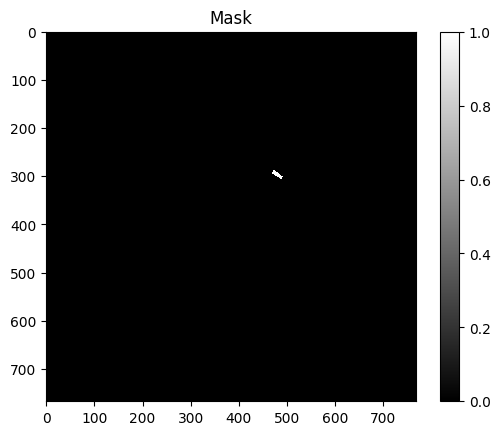

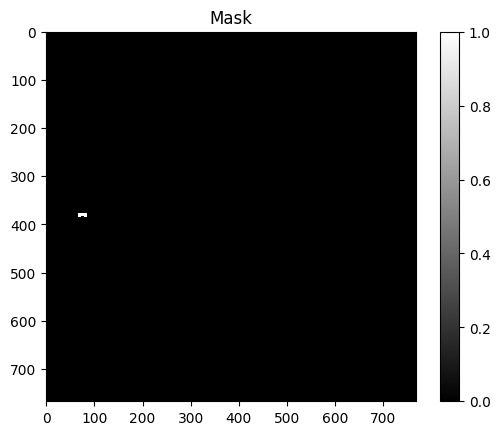

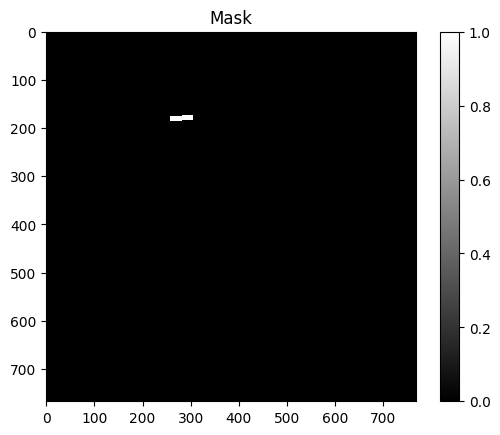

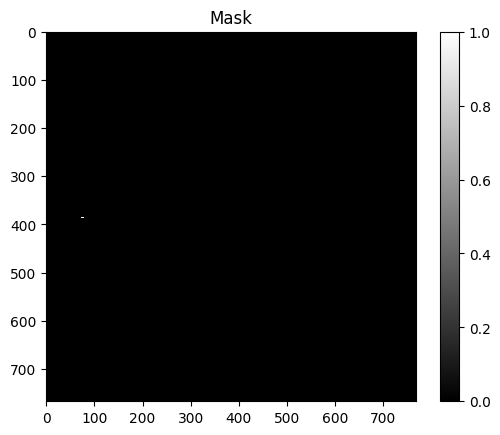

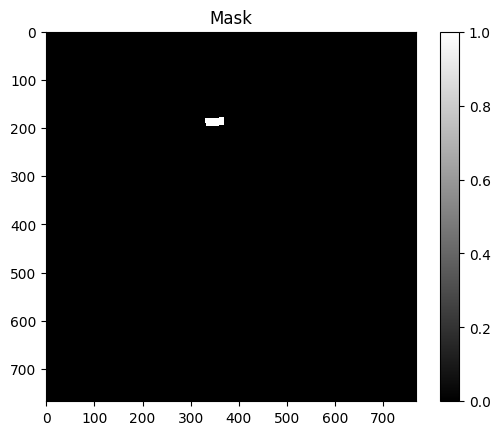

In [19]:
for label, img_id in zip(labels[3:8], img_ids[3:8]):
    mask = Create_mask(label, config['original_img_size'])
    plt.imshow(mask, cmap='gray', interpolation='nearest')
    plt.title('Mask')
    plt.colorbar()
    plt.show()

# Mask precompute

In [14]:
for label, img_id in tqdm(zip(labels, img_ids), total=len(labels)):
    mask = Create_mask(label, config['original_img_size'])
    res_mask = resizer(torch.tensor(mask).unsqueeze(0))
    perm_mask = res_mask.permute(1, 2, 0)
    cv2.imwrite(config['dataset']['mask_path'] + "/" + "mask" + img_id, np.uint8(perm_mask.numpy()))

  0%|                                                                                       | 0/231723 [00:00<?, ?it/s]C:\Users\da4nik\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|                                                                            | 128/231723 [00:00<05:46, 668.87it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  0%|                                                                            | 285/231723 [00:00<05:11, 743.63it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  0%|▏                                                                           | 442/231723 [00:00<05:00, 768.95it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  0%|▏                                                                           | 603/231723 [00:00<04:53, 786.93it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  0%|▏                                                                           | 757/231723 [00:01<05:22, 717.01it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  0%|▎                                                                           | 908/231723 [00:01<05:15, 730.53it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  0%|▎                                                                          | 1075/231723 [00:01<04:55, 780.05it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  1%|▍                                                                          | 1232/231723 [00:01<04:59, 770.87it/s]

tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  1%|▍                                                                          | 1476/231723 [00:01<04:55, 780.14it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  1%|▌                                                                          | 1634/231723 [00:02<04:58, 771.32it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  1%|▌                                                                          | 1712/231723 [00:02<04:58, 769.32it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  1%|▌                                                                          | 1877/231723 [00:02<04:48, 797.69it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  1%|▋                                                                          | 2050/231723 [00:02<04:52, 784.16it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  1%|▋                                                                          | 2211/231723 [00:02<04:55, 776.55it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  1%|▊                                                                          | 2376/231723 [00:03<04:47, 798.45it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  1%|▊                                                                          | 2538/231723 [00:03<04:50, 789.46it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  1%|▊                                                                          | 2698/231723 [00:03<04:49, 789.76it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  1%|▉                                                                          | 2863/231723 [00:03<04:43, 806.22it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  1%|▉                                                                          | 3028/231723 [00:03<04:48, 793.89it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  1%|█                                                                          | 3189/231723 [00:04<04:46, 796.59it/s]

tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  1%|█                                                                          | 3357/231723 [00:04<04:46, 797.67it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  2%|█▏                                                                         | 3516/231723 [00:04<04:51, 782.41it/s]

tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  2%|█▏                                                                         | 3675/231723 [00:04<04:52, 779.42it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  2%|█▏                                                                         | 3837/231723 [00:04<04:47, 791.47it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  2%|█▎                                                                         | 3917/231723 [00:05<04:48, 789.27it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  2%|█▎                                                                         | 4154/231723 [00:05<05:21, 708.47it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  2%|█▍                                                                         | 4307/231723 [00:05<05:10, 732.83it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  2%|█▍                                                                         | 4457/231723 [00:05<05:07, 739.73it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  2%|█▍                                                                         | 4612/231723 [00:06<05:00, 756.54it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  2%|█▌                                                                         | 4689/231723 [00:06<05:07, 738.64it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  2%|█▌                                                                         | 4858/231723 [00:06<04:53, 773.99it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  2%|█▋                                                                         | 5027/231723 [00:06<04:40, 809.29it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  2%|█▋                                                                         | 5190/231723 [00:06<04:48, 784.82it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  2%|█▋                                                                         | 5362/231723 [00:06<04:36, 817.86it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  2%|█▊                                                                         | 5528/231723 [00:07<04:38, 812.35it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  2%|█▊                                                                         | 5690/231723 [00:07<04:50, 777.37it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  3%|█▉                                                                         | 5868/231723 [00:07<04:41, 802.89it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  3%|█▉                                                                         | 6034/231723 [00:07<04:39, 806.58it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  3%|██                                                                         | 6204/231723 [00:08<04:33, 823.25it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  3%|██                                                                         | 6367/231723 [00:08<04:55, 763.83it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  3%|██                                                                         | 6540/231723 [00:08<04:35, 818.04it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  3%|██▏                                                                        | 6719/231723 [00:08<04:22, 858.61it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  3%|██▏                                                                        | 6896/231723 [00:08<04:18, 871.36it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  3%|██▎                                                                        | 7071/231723 [00:09<04:26, 843.95it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  3%|██▎                                                                        | 7332/231723 [00:09<04:20, 862.81it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  3%|██▍                                                                        | 7512/231723 [00:09<04:15, 876.91it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  3%|██▍                                                                        | 7693/231723 [00:09<04:11, 891.47it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  3%|██▌                                                                        | 7871/231723 [00:09<04:15, 876.88it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  3%|██▌                                                                        | 7959/231723 [00:10<04:20, 857.44it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  4%|██▋                                                                        | 8127/231723 [00:10<04:36, 809.63it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  4%|██▋                                                                        | 8290/231723 [00:10<04:41, 792.85it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  4%|██▋                                                                        | 8449/231723 [00:10<04:46, 779.51it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  4%|██▊                                                                        | 8612/231723 [00:10<04:41, 792.80it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  4%|██▊                                                                        | 8772/231723 [00:11<04:41, 790.72it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  4%|██▉                                                                        | 8929/231723 [00:11<04:58, 746.33it/s]

tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  4%|██▉                                                                        | 9083/231723 [00:11<04:53, 758.14it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  4%|██▉                                                                        | 9240/231723 [00:11<04:48, 771.08it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  4%|███                                                                        | 9401/231723 [00:11<04:41, 788.74it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  4%|███                                                                        | 9565/231723 [00:12<04:40, 791.80it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  4%|███▏                                                                       | 9726/231723 [00:12<04:38, 797.93it/s]

tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  4%|███▏                                                                       | 9896/231723 [00:12<04:32, 812.72it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  4%|███▏                                                                      | 10059/231723 [00:12<04:36, 801.22it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  4%|███▎                                                                      | 10230/231723 [00:12<04:36, 800.61it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  4%|███▎                                                                      | 10391/231723 [00:13<04:41, 785.67it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  5%|███▎                                                                      | 10549/231723 [00:13<04:46, 771.88it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  5%|███▍                                                                      | 10705/231723 [00:13<04:51, 757.16it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  5%|███▍                                                                      | 10937/231723 [00:13<04:49, 762.54it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  5%|███▌                                                                      | 11099/231723 [00:14<04:41, 785.07it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  5%|███▌                                                                      | 11257/231723 [00:14<04:44, 776.16it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  5%|███▌                                                                      | 11344/231723 [00:14<04:34, 803.76it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  5%|███▋                                                                      | 11503/231723 [00:14<04:48, 764.26it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  5%|███▋                                                                      | 11670/231723 [00:14<04:35, 798.91it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  5%|███▊                                                                      | 11913/231723 [00:15<04:38, 787.96it/s]

tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  5%|███▊                                                                      | 11992/231723 [00:15<04:42, 777.11it/s]

tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  5%|███▉                                                                      | 12163/231723 [00:15<04:38, 787.42it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  5%|███▉                                                                      | 12321/231723 [00:15<04:40, 782.21it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  5%|████                                                                      | 12562/231723 [00:15<04:35, 796.20it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  5%|████                                                                      | 12726/231723 [00:16<04:40, 781.06it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  6%|████                                                                      | 12883/231723 [00:16<04:43, 770.74it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  6%|████▏                                                                     | 13039/231723 [00:16<04:46, 763.55it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  6%|████▏                                                                     | 13116/231723 [00:16<04:50, 752.16it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  6%|████▏                                                                     | 13297/231723 [00:16<04:22, 833.32it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  6%|████▎                                                                     | 13464/231723 [00:17<04:33, 799.20it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  6%|████▎                                                                     | 13623/231723 [00:17<04:50, 751.54it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  6%|████▍                                                                     | 13776/231723 [00:17<04:54, 739.95it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  6%|████▍                                                                     | 13924/231723 [00:17<05:07, 707.99it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  6%|████▍                                                                     | 14082/231723 [00:17<04:50, 748.53it/s]

tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  6%|████▌                                                                     | 14237/231723 [00:18<04:45, 762.76it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  6%|████▌                                                                     | 14395/231723 [00:18<04:39, 776.44it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  6%|████▋                                                                     | 14556/231723 [00:18<04:35, 788.93it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  6%|████▋                                                                     | 14723/231723 [00:18<04:27, 810.58it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  6%|████▋                                                                     | 14805/231723 [00:18<04:27, 810.57it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  6%|████▊                                                                     | 15051/231723 [00:19<04:57, 728.19it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  7%|████▊                                                                     | 15209/231723 [00:19<04:46, 754.94it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  7%|████▉                                                                     | 15289/231723 [00:19<04:41, 767.86it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  7%|████▉                                                                     | 15451/231723 [00:19<04:33, 790.29it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  7%|████▉                                                                     | 15607/231723 [00:19<05:07, 703.39it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  7%|█████                                                                     | 15758/231723 [00:20<05:00, 718.71it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  7%|█████                                                                     | 15900/231723 [00:20<05:21, 672.31it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  7%|█████▏                                                                    | 16049/231723 [00:20<05:02, 712.32it/s]

tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  7%|█████▏                                                                    | 16200/231723 [00:20<04:58, 721.60it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  7%|█████▏                                                                    | 16365/231723 [00:21<04:37, 776.52it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  7%|█████▎                                                                    | 16519/231723 [00:21<04:58, 720.88it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  7%|█████▎                                                                    | 16665/231723 [00:21<04:59, 717.61it/s]

tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  7%|█████▎                                                                    | 16820/231723 [00:21<05:00, 714.58it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  7%|█████▍                                                                    | 16972/231723 [00:21<04:52, 733.31it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  7%|█████▍                                                                    | 17123/231723 [00:22<04:49, 742.35it/s]

tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  7%|█████▌                                                                    | 17275/231723 [00:22<04:48, 744.32it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  8%|█████▌                                                                    | 17442/231723 [00:22<04:37, 772.23it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  8%|█████▌                                                                    | 17601/231723 [00:22<04:38, 768.33it/s]

tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  8%|█████▋                                                                    | 17758/231723 [00:22<04:40, 762.67it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  8%|█████▋                                                                    | 17925/231723 [00:23<04:27, 797.92it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  8%|█████▊                                                                    | 18084/231723 [00:23<04:33, 782.45it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  8%|█████▊                                                                    | 18243/231723 [00:23<04:34, 777.42it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  8%|█████▉                                                                    | 18400/231723 [00:23<04:38, 765.72it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  8%|█████▉                                                                    | 18656/231723 [00:24<04:21, 816.06it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  8%|██████                                                                    | 18827/231723 [00:24<04:16, 829.40it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  8%|██████                                                                    | 19003/231723 [00:24<04:09, 854.04it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  8%|██████                                                                    | 19089/231723 [00:24<04:15, 830.92it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  8%|██████▏                                                                   | 19253/231723 [00:24<04:29, 788.92it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  8%|██████▏                                                                   | 19416/231723 [00:24<04:24, 803.05it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  8%|██████▎                                                                   | 19581/231723 [00:25<04:22, 806.97it/s]

tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  9%|██████▎                                                                   | 19753/231723 [00:25<04:14, 832.69it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  9%|██████▍                                                                   | 20014/231723 [00:25<04:08, 851.65it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  9%|██████▍                                                                   | 20186/231723 [00:25<04:10, 843.46it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  9%|██████▍                                                                   | 20271/231723 [00:25<04:19, 816.37it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  9%|██████▌                                                                   | 20432/231723 [00:26<04:42, 746.98it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  9%|██████▌                                                                   | 20580/231723 [00:26<05:07, 687.07it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  9%|██████▌                                                                   | 20650/231723 [00:26<05:23, 653.04it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  9%|██████▋                                                                   | 20780/231723 [00:26<05:33, 633.09it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  9%|██████▋                                                                   | 20907/231723 [00:27<05:42, 615.45it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  9%|██████▋                                                                   | 21037/231723 [00:27<05:34, 630.53it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  9%|██████▊                                                                   | 21168/231723 [00:27<05:29, 639.34it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  9%|██████▊                                                                   | 21297/231723 [00:27<05:39, 620.19it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  9%|██████▊                                                                   | 21433/231723 [00:27<05:24, 647.52it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  9%|██████▊                                                                   | 21500/231723 [00:27<05:21, 654.09it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  9%|██████▉                                                                   | 21688/231723 [00:28<06:06, 572.65it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  9%|██████▉                                                                   | 21820/231723 [00:28<05:40, 617.26it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  9%|██████▉                                                                   | 21884/231723 [00:28<05:37, 621.98it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  9%|███████                                                                   | 22010/231723 [00:28<06:21, 550.34it/s]

tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

 10%|███████                                                                   | 22136/231723 [00:29<05:56, 587.95it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

 10%|███████                                                                   | 22260/231723 [00:29<05:53, 593.17it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

 10%|███████▏                                                                  | 22322/231723 [00:29<05:49, 599.15it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

 10%|███████▏                                                                  | 22439/231723 [00:29<06:46, 514.81it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

 10%|███████▏                                                                  | 22547/231723 [00:29<06:52, 507.69it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

 10%|███████▏                                                                  | 22607/231723 [00:29<06:32, 533.11it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

 10%|███████▎                                                                  | 22785/231723 [00:30<06:25, 541.70it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

 10%|███████▎                                                                  | 22850/231723 [00:30<06:05, 572.07it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

 10%|███████▎                                                                  | 22982/231723 [00:30<05:44, 605.48it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

 10%|███████▍                                                                  | 23123/231723 [00:30<05:18, 655.12it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

 10%|███████▍                                                                  | 23274/231723 [00:31<04:57, 701.57it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

 10%|███████▌                                                                  | 23493/231723 [00:31<04:54, 705.88it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

 10%|███████▌                                                                  | 23637/231723 [00:31<04:53, 707.93it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

 10%|███████▌                                                                  | 23779/231723 [00:31<04:56, 701.19it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

 10%|███████▋                                                                  | 23924/231723 [00:31<04:54, 706.33it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

 10%|███████▋                                                                  | 24068/231723 [00:32<04:51, 712.60it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

 10%|███████▋                                                                  | 24132/231723 [00:32<04:37, 748.85it/s]


tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

KeyboardInterrupt: 

# Data preview

In [9]:
train_ship_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB


# Create mask

In [15]:
def Create_mask(labels, img_size):
    mask = np.zeros(img_size*img_size, np.int8)
    if len(labels) > 1:
        np_lbl = np.asarray(labels, dtype=int)
        for i in range(0, len(np_lbl), 2):
            # Create a tuple of even and odd numbers
            start_ind = np_lbl[i]
            end_ind = np_lbl[i] + np_lbl[i + 1]
            mask[start_ind:end_ind] = 1.0

    return mask.reshape((img_size, img_size)).T

In [9]:
mask = Create_mask(train_ship_data.iloc[2]["EncodedPixels"].split(" "), config['original_img_size'])

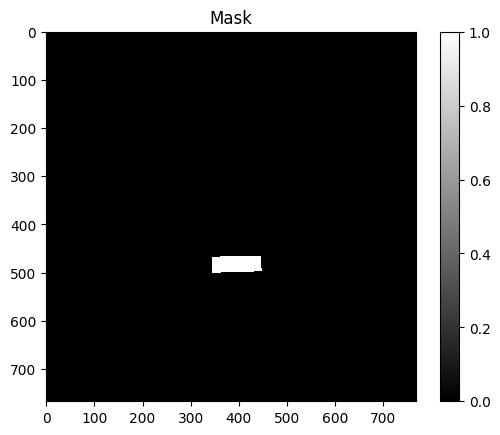

In [10]:
plt.imshow(mask, cmap='gray', interpolation='nearest')
plt.title('Mask')
plt.colorbar()
plt.show()

# Image

80472f2362.jpg


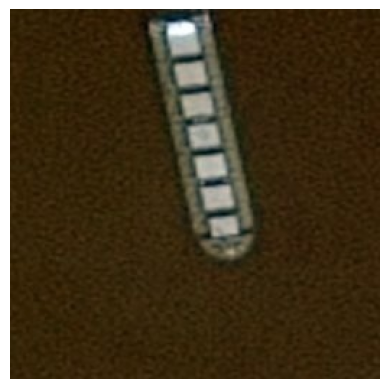

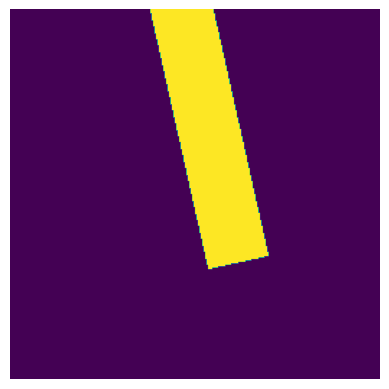

37a6423ca0.jpg


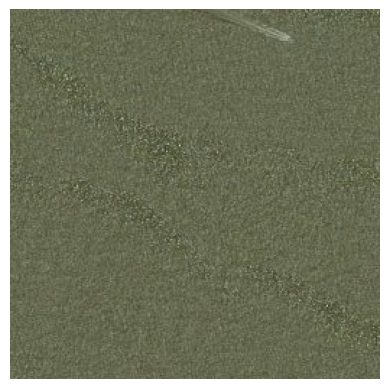

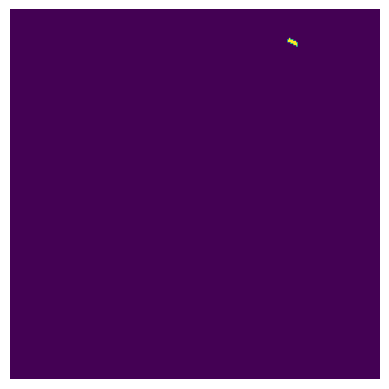

1643b33354.jpg


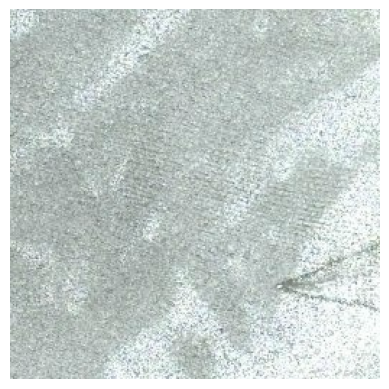

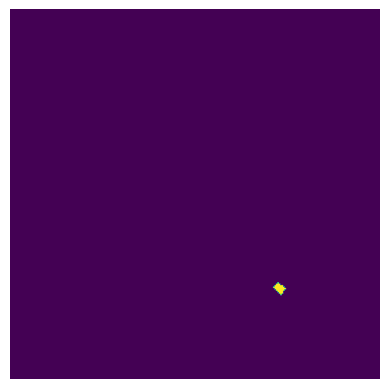

00aad46408.jpg


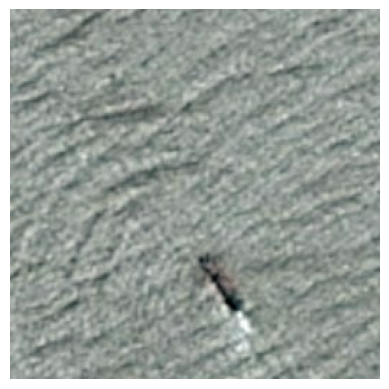

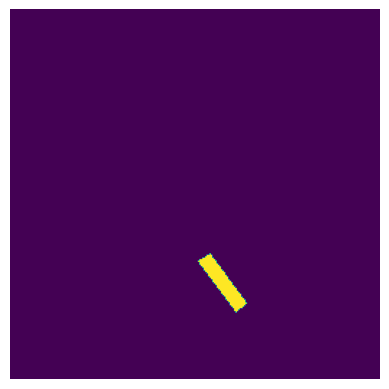

52138304af.jpg


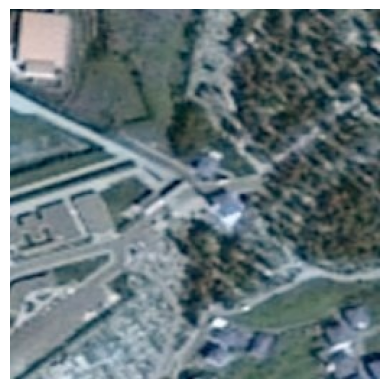

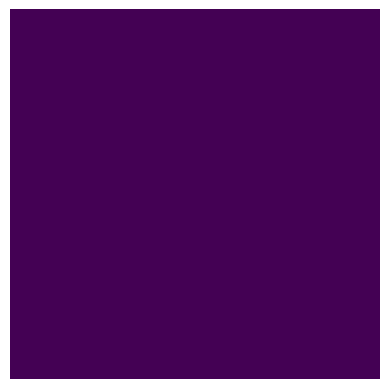

In [14]:
for img_id, mask_id in zip(listl[0:5], mask_ids[0:5]):
    mask = np.load(config['dataset']['mask_path'] + "/" + mask_id)        
    image = cv2.imread(config['dataset']['reshaped_img_path'] + "/" + img_id)
    print(img_id)
    plt.imshow(image)
    plt.axis('off')  # Turn off axis
    plt.show()
    plt.imshow(mask)
    plt.axis('off')  # Turn off axis
    plt.show()

# Recall & Precision

In [2]:
def TruePositive(actualv, predictedv):
    return np.sum((np.round(predictedv) == 1) & (actualv == 1))

In [3]:
def FalseNegative(actualv, predictedv):
    return np.sum((np.round(predictedv) == 0) & (actualv == 1))

In [4]:
def FalsePositive(actualv, predictedv):
    return np.sum((np.round(predictedv) == 1) & (actualv == 0))

In [5]:
def TrueNegative(actualv, predictedv):
    return np.sum((np.round(predictedv) == 0) & (actualv == 0))

In [9]:
def RecallAndPrecision(actualv, predictedv):
    actualv = actualv.numpy(force=True)
    predictedv = predictedv.numpy(force=True)
    TP = TruePositive(actualv, predictedv)
    FN = FalseNegative(actualv, predictedv)
    FP = FalsePositive(actualv, predictedv)
    TN = TrueNegative(actualv, predictedv)
    recall = TP / (TP + FN) if TP + FN != 0 else 0
    precisoin = TP / (TP + FP) if TP + FP != 0 else 0
    return recall, precisoin, (TP, FN, FP, TN)

In [9]:
actualv = torch.tensor([1, 0, 1, 1], dtype=torch.float32)
predictedv = torch.tensor([0.8, 0.3, 0.7, 0.1], dtype=torch.float32)  # Example values between 0 and 1
recall, precision, metrics = RecallAndPrecision(actualv, predictedv)
print("Recall:", recall)
print("Precision:", precision)
print("Metrics:", metrics)

Recall: 0.6666666666666666
Precision: 1.0
Metrics: (2, 1, 0, 1)
